# Parallel Wiener-Hammerstein system

See http://arxiv.org/pdf/1708.06543 for more information on the dataset.

Note that running this file multiple times, or on different machines, with the same parameters may yield different results due to the non-deterministic nature of GPU parallel execution.

In [1]:
import matplotlib.pyplot as plt
import nonlinear_benchmarks as nlb
import numpy as np
import optimistix as optx
from matplotlib import rcParams
from nonlinear_benchmarks.error_metrics import RMSE

import freq_statespace as fss


# Load data
ParWH_full_train, ParWH_full_test = nlb.ParWH() 

# Initialize variables
N = 16384  # number of samples per period
R = 5  # number of random phase multisine realizations
P = 2  # number of periods
amplitude_level = 4  # must be one of {0, 1, 2, 3, 4}

nu, ny = 1, 1  # SISO system

fs = 78e3  # [Hz]
f_idx = np.arange(1, 4096)  # frequency lines of interest (excludes DC)

# Load data
ParWH_full_train, ParWH_full_test = nlb.ParWH() 
ParWH_train = [
    data for data in ParWH_full_train
    for phase in range(R)
    if data.name == f'Est-phase-{phase}-amp-{amplitude_level}'
]
ParWH_test = [
    data for data in ParWH_full_test
    if data.name == f'Val-amp-{amplitude_level}'
][0]

# Preprocess data
u_train = np.array([data.u for data in ParWH_train]).reshape(R, nu, N, P)
y_train = np.array([data.y for data in ParWH_train]).reshape(R, ny, N, P)
u_train = np.transpose(u_train, (2, 1, 0, 3))
y_train = np.transpose(y_train, (2, 1, 0, 3))

u_test = np.transpose(ParWH_test.u.reshape(1, nu, N, 2), (2, 1, 0, 3))
y_test = np.transpose(ParWH_test.y.reshape(1, ny, N, 2), (2, 1, 0, 3))

# Create input-output training data object
data = fss.create_data_object(u_train, y_train, f_idx, fs)

In [ ]:
# Fit Best Linear Approximation

# (i) Parametrize using frequency-domain subspace identification method
nx = 12  # number of states
nq = 14 if amplitude_level == 0 else 13  # larger nq at lowest level for stability 
bla_fsid = fss.lin.subspace_id(data, nx, nq)

# (ii) Frequency-domain iterative optimization starting from FSID BLA
max_iter = 10 if amplitude_level == 0 else 100
solver = optx.LevenbergMarquardt(rtol=1e-3, atol=1e-6)
bla_opti = fss.lin.optimize(bla_fsid, data, solver=solver, max_iter=max_iter, print_every=10)

=============== Frequency-domain subspace identification ===============
BLA simulation error: 13.31%.

=========================== BLA optimization ===========================
Starting iterative optimization...
    Iter 1 | loss = 4.3606e-01
    Iter 11 | loss = 2.8645e-01
    Iter 21 | loss = 2.8022e-01
    Iter 31 | loss = 2.7275e-01
    Iter 41 | loss = 2.6031e-01
    Iter 51 | loss = 2.5915e-01
    Iter 61 | loss = 2.5873e-01
    Iter 71 | loss = 2.5862e-01
    Iter 81 | loss = 2.5861e-01
    Iter 91 | loss = 2.5859e-01
Optimization completed in 2.36s (100 iterations, 22.18ms/iter).

BLA simulation error: 11.18%.



In [ ]:
### Inference and learning of NL-LFR model ###

# Define the nonlinear basis function
degree = 7
nw = 2
nz = 2
phi = fss.static.basis.Polynomial(nz, degree)

# As for the solver, we typically prefer a dedicated least-squares solver,
# such as the Levenberg-Marquardt (LM) algorithm. However, these solvers tend to have
# a high memory footprint, which can quickly become prohibitive for large-scale problems
# (like the one at hand). Your machine may not have enough memory to run it.
#
# This is especially true for our inference and learning approach, which involves:
# - fixed-point iterations within the loss function (though this can be mitigated by
#   setting `recompute_fixed_point=True` in `fss.nonlin.inference_and_learning`, at the
#   cost of increased computation time),
# - large feature matrices from nonlinear basis expansions,
# - multiple FFT operations and reshaping steps,
# all of which contribute to a large autodiff trace and memory pressure under LM.
#
# Fortunately, we can also opt for general-purpose minimizers that are more
# memory-efficient, such as BFGS or any first-order optimizer from the Optax library!
# These only require the gradient of a scalar loss and avoid tracing through the full
# residual or Jacobian.
#
# Example solver choices:
# solver = optx.LevenbergMarquardt(rtol=1e-3, atol=1e-6)
# solver = optx.OptaxMinimiser(optax.adam(learning_rate=1e-3), rtol=1e-3, atol=1e-6)
# solver = optx.BFGS(rtol=1e-3, atol=1e-6)

# Solve the problem
solver = optx.BFGS(rtol=1e-3, atol=1e-6)
lambda_w = 1e2 if amplitude_level == 0 else 1  # more regularization at lowest level due to poor SNR
nllfr_init = fss.nonlin.inference_and_learning(
    bla_opti, data, phi, nw, lambda_w=lambda_w, solver=solver, print_every=10
)

==================== NL-LFR inference and learning =====================
Starting iterative optimization...
    BLA loss: 4.0268e+04
    Iter 1 | loss = 4.4408e+04
    Iter 11 | loss = 4.4408e+04
    Iter 21 | loss = 3.7382e+04
    Iter 31 | loss = 2.6588e+04
    Iter 41 | loss = 2.3780e+04
    Iter 51 | loss = 2.3780e+04
    Iter 61 | loss = 1.4308e+04
    Iter 71 | loss = 1.1277e+04
    Iter 81 | loss = 1.0326e+04
    Iter 91 | loss = 8.9334e+03
    Iter 101 | loss = 8.4433e+03
    Iter 111 | loss = 8.4433e+03
    Iter 121 | loss = 8.2340e+03
    Iter 131 | loss = 7.7456e+03
    Iter 141 | loss = 7.1191e+03
    Iter 151 | loss = 6.9199e+03
    Iter 161 | loss = 6.9199e+03
    Iter 171 | loss = 6.7332e+03
    Iter 181 | loss = 6.6735e+03
    Iter 191 | loss = 6.4959e+03
    Iter 201 | loss = 6.4959e+03
    Iter 211 | loss = 6.1030e+03
    Iter 221 | loss = 5.3431e+03
    Iter 231 | loss = 5.2285e+03
    Iter 241 | loss = 4.9156e+03
    Iter 251 | loss = 4.6285e+03
    Iter 261 | loss 

In [ ]:
### Final optimization ###

# Regarding the solver, the same story as above applies. But this optimization step is a
# bit less  memory-hungry than inference and learning, so we can afford to use a more 
# powerful solver.
#
# Example solver choices:
# solver = optx.LevenbergMarquardt(rtol=1e-3, atol=1e-6)
# solver = optx.OptaxMinimiser(optax.adam(learning_rate=2e-5), rtol=1e-3, atol=1e-6)
# solver = optx.BFGS(rtol=1e-3, atol=1e-6)

# Solve the problem
solver = optx.LevenbergMarquardt(rtol=1e-3, atol=1e-6)
nllfr_opti = fss.nonlin.optimize(nllfr_init, data, solver=solver, max_iter=250, print_every=10)

========================= NL-LFR optimization ==========================
Starting iterative optimization...
    BLA loss: 4.0268e+04
    Iter 1 | loss = 1.0333e+03
    Iter 11 | loss = 7.9719e+02
    Iter 21 | loss = 3.7241e+02
    Iter 31 | loss = 2.9074e+02
    Iter 41 | loss = 2.6077e+02
    Iter 51 | loss = 2.3887e+02
    Iter 61 | loss = 2.1725e+02
    Iter 71 | loss = 1.9221e+02
    Iter 81 | loss = 1.6456e+02
    Iter 91 | loss = 1.4119e+02
    Iter 101 | loss = 1.2365e+02
    Iter 111 | loss = 1.0909e+02
    Iter 121 | loss = 9.8010e+01
    Iter 131 | loss = 8.9463e+01
    Iter 141 | loss = 8.2655e+01
    Iter 151 | loss = 6.8156e+01
    Iter 161 | loss = 6.0060e+01
    Iter 171 | loss = 4.8971e+01
    Iter 181 | loss = 4.3644e+01
    Iter 191 | loss = 4.0446e+01
    Iter 201 | loss = 3.8430e+01
    Iter 211 | loss = 3.7007e+01
    Iter 221 | loss = 3.5896e+01
    Iter 231 | loss = 3.4993e+01
    Iter 241 | loss = 3.4237e+01
Optimization completed in 602.50s (250 iterations, 2.

NRMSE of BLA model on test data: 11.29%
NRMSE of NL-LFR model on test data: 0.36%


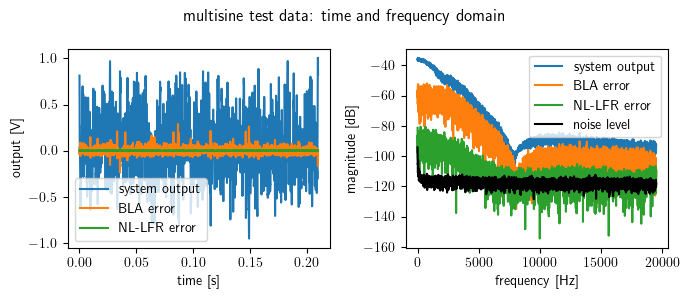

In [ ]:
### Evaluate on test data ###

# Enable LaTeX rendering for text
rcParams['text.usetex'] = True

# Simulate BLA and NL-LFR models
y_test_bla = bla_opti.simulate(u_test)[0]
y_test_nllfr = nllfr_opti.simulate(u_test)[0]

# Only select the second steady-state period
y_test = y_test[..., 1].squeeze()
y_test_bla = y_test_bla[..., 1].squeeze()
y_test_nllfr = y_test_nllfr[..., 1].squeeze()
        
# Compute and print errors
e_test_bla = y_test - y_test_bla
e_test_nllfr = y_test - y_test_nllfr
mse_bla = np.mean((e_test_bla)**2)
mse_nllfr_lfr = np.mean((e_test_nllfr)**2)
norm = np.mean(y_test**2)
print(f'NRMSE of BLA model on test data: {100 * np.sqrt(mse_bla / norm):.2f}%')
print(f'NRMSE of NL-LFR model on test data: {100 * np.sqrt(mse_nllfr_lfr / norm):.2f}%')

# Convert to frequency domain
Y_test = np.fft.rfft(y_test, norm='forward')
E_test_bla = np.fft.rfft(e_test_bla, norm='forward')
E_test_nonlin_lfr = np.fft.rfft(e_test_nllfr, norm='forward')

# Compute noise level
Y_noise_std = np.sqrt(data.freq.Y_var_noise)
Y_noise_std = 1 / N * Y_noise_std * data.norm.y_std  # denormalize

t = data.time.t
f = data.freq.f[f_idx]

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs[0].plot(t, y_test, label='system output')
axs[0].plot(t, e_test_bla, label='BLA error')
axs[0].plot(t, e_test_nllfr, label='NL-LFR error')
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('output [V]')
axs[0].legend()

axs[1].plot(f, 20*np.log10(np.abs(Y_test[f_idx])), label='system output')
axs[1].plot(f, 20*np.log10(np.abs(E_test_bla[f_idx])), label='BLA error')
axs[1].plot(f, 20*np.log10(np.abs(E_test_nonlin_lfr[f_idx])), label='NL-LFR error')
axs[1].plot(f, 20*np.log10(Y_noise_std[f_idx]), 'k', label='noise level')
axs[1].set_xlabel('frequency [Hz]')
axs[1].set_ylabel('magnitude [dB]')
axs[1].legend()
fig.suptitle("multisine test data: time and frequency domain", fontsize=12)
plt.tight_layout()
plt.show()

In [7]:
# Official reporting for nonlinear benchmark submission
state_init_window_length = 50  # found in recent nonlinear_benchmark commit `c74fb1b`
rmse = RMSE(y_test[state_init_window_length:], y_test_nllfr[state_init_window_length:])
print(f'Amplitude level {amplitude_level}, test RMSE: {1000 * rmse:.4f} mV')

Amplitude level 4, test RMSE: 1.1968 mV
